# Image Classification with Logistic Regression (Minimal)

- [Dataset & Data loaders](#data)
- [Model](#model)
- [Training](#training)
- [Prediction](#prediction)
- [Save model](#save)
- [Load model](#load)


<div id='xx' />

In [1]:
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import random_split
from torch.utils.data import DataLoader

In [2]:
# Hyperparmeters
batch_size = 128
learning_rate = 0.001

# Other constants
px = 28
input_size = px ** 2
num_classes = 10

<div id='data' />

## Dataset & Data loaders

In [3]:
# Download dataset
dataset = MNIST(root='../data/pytorch_data', train=True, transform=transforms.ToTensor(), download=True)

# Training validation & test dataset
train_ds, val_ds = random_split(dataset, [50000, 10000])
test_ds = MNIST(root='../data/pytorch_data/', train=False, transform=transforms.ToTensor())

# Dataloaders
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)
test_loader = DataLoader(test_ds, batch_size*2)

Label: 5


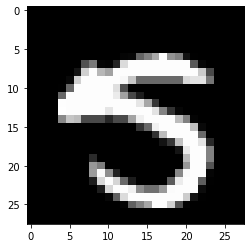

In [4]:
image, label = train_ds[0]
plt.imshow(image[0], cmap="gray")
print("Label:", label)

<div id='model' />

## Model

In [5]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, px ** 2)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {"val_loss": loss.detach(), "val_acc": acc.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x["val_acc"] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {"val_loss": epoch_loss.item(), "val_acc": epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result["val_loss"], result["val_acc"]))
    
model = MnistModel()

<div id='training' />

## Training

In [6]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [7]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [8]:
evaluate(model, val_loader)

{'val_loss': 2.280778408050537, 'val_acc': 0.11181640625}

In [9]:
history = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.9253, val_acc: 0.6178
Epoch [1], val_loss: 1.6623, val_acc: 0.7310
Epoch [2], val_loss: 1.4659, val_acc: 0.7621
Epoch [3], val_loss: 1.3177, val_acc: 0.7813
Epoch [4], val_loss: 1.2035, val_acc: 0.7938


Text(0.5, 1.0, 'Accuracy vs Epochs')

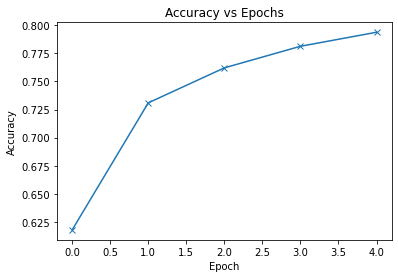

In [10]:
accuracies = [r["val_acc"] for r in history]
plt.plot(accuracies, "-x")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs")

In [11]:
# Evaluate on test dataset
result = evaluate(model, test_loader)
result

{'val_loss': 1.1802494525909424, 'val_acc': 0.803027331829071}

<div id='prediction' />

## Prediction

In [12]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 2 , Predicted: 1


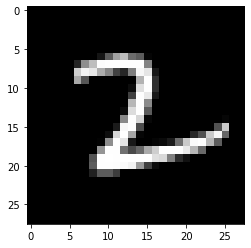

In [13]:
img, label = test_ds[919]
plt.imshow(img[0], cmap="gray")
print("Label:", label, ", Predicted:", predict_image(img, model))

<div id='save' />

## Save model

In [14]:
torch.save(model.state_dict(), "models/mnist-logistic.pth")

In [15]:
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.0200, -0.0178, -0.0061,  ...,  0.0019, -0.0301,  0.0027],
                      [ 0.0163,  0.0131,  0.0353,  ...,  0.0083,  0.0284, -0.0083],
                      [ 0.0345, -0.0162,  0.0018,  ...,  0.0180,  0.0137,  0.0151],
                      ...,
                      [-0.0127, -0.0213, -0.0275,  ..., -0.0292,  0.0245,  0.0252],
                      [ 0.0076,  0.0012,  0.0243,  ..., -0.0243,  0.0059,  0.0088],
                      [ 0.0303,  0.0336,  0.0150,  ..., -0.0131, -0.0215,  0.0320]])),
             ('linear.bias',
              tensor([ 0.0132,  0.0489, -0.0077,  0.0260, -0.0050, -0.0245,  0.0183,  0.0078,
                      -0.0187, -0.0187]))])

<div id='load' />

## Load model

In [16]:
model2 = MnistModel()
model2.load_state_dict(torch.load("models/mnist-logistic.pth"))
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.0200, -0.0178, -0.0061,  ...,  0.0019, -0.0301,  0.0027],
                      [ 0.0163,  0.0131,  0.0353,  ...,  0.0083,  0.0284, -0.0083],
                      [ 0.0345, -0.0162,  0.0018,  ...,  0.0180,  0.0137,  0.0151],
                      ...,
                      [-0.0127, -0.0213, -0.0275,  ..., -0.0292,  0.0245,  0.0252],
                      [ 0.0076,  0.0012,  0.0243,  ..., -0.0243,  0.0059,  0.0088],
                      [ 0.0303,  0.0336,  0.0150,  ..., -0.0131, -0.0215,  0.0320]])),
             ('linear.bias',
              tensor([ 0.0132,  0.0489, -0.0077,  0.0260, -0.0050, -0.0245,  0.0183,  0.0078,
                      -0.0187, -0.0187]))])